In [8]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd 
import numpy as np
from tqdm import tqdm
import pickle
import os

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from yellowbrick.classifier import DiscriminationThreshold

import warnings
warnings.filterwarnings("ignore")

from drive.MyDrive.Quora_Duplicate_Questions.src.functions import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
set_seed(69)

PATH = 'drive/MyDrive/Quora_Duplicate_Questions/'
data = pd.read_csv(PATH+'src/data_engineered.csv', index_col='id')

fs1 = ['q1_len', 'q2_len', 'len_difference', 'len_abs_difference',
       'q1_char_len', 'q2_char_len', 'q1_num_words', 'q2_num_words',
       'q1_freq', 'q2_freq', 'total_freq', 'abs_diff_freq', 
        'num_common_words', 'ratio_common_words']

fs2 = ['fuzz_qratio', 'fuzz_Wratio', 'fuzz_partial_ratio', 
       'fuzz_partial_token_set_ratio', 'fuzz_partial_token_sort_ratio',
       'fuzz_token_set_ratio', 'fuzz_token_sort_ratio']

fs3_1 = get_pickle('fs3_1')
fs3_2 = get_pickle('fs3_2')
fs3_3 = get_pickle('fs3_3')
fs3_4 = get_pickle('fs3_4')
fs3_5 = get_pickle('fs3_5')

fs4_1 = ['cosine_distance', 'cityblock_distance', 
         'jaccard_distance', 'canberra_distance', 
         'euclidean_distance', 'minkowski_distance',
         'braycurtis_distance']

fs4_2 = ['wmd', 'norm_wmd']

w2v = get_pickle('w2v')

In [5]:
scaler = StandardScaler()
y = data.is_duplicate.values
y = y.astype('float32').reshape(-1, 1)
X = data[fs1+fs2+fs4_1+fs4_2]
X = X.replace([np.inf, -np.inf], np.nan).fillna(0).values
X = scaler.fit_transform(X)
X = np.hstack((X, fs3_3, fs3_4, fs3_5, w2v))
X = pd.DataFrame(X, columns=fs1+fs2+fs4_1+fs4_2+[f'fs3_3_{i}' for i in range(fs3_3.shape[1])]+[f'fs3_4_{i}' for i in range(fs3_4.shape[1])]+[f'fs3_5_{i}' for i in range(fs3_5.shape[1])]+[f'w2v_{i}' for i in range(w2v.shape[1])])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
lr = LogisticRegression(max_iter=1000, C=5)

lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
print(classification_report(y_test, lr_preds))

              precision    recall  f1-score   support

         0.0       0.81      0.87      0.84     50964
         1.0       0.75      0.66      0.70     29894

    accuracy                           0.79     80858
   macro avg       0.78      0.76      0.77     80858
weighted avg       0.79      0.79      0.79     80858



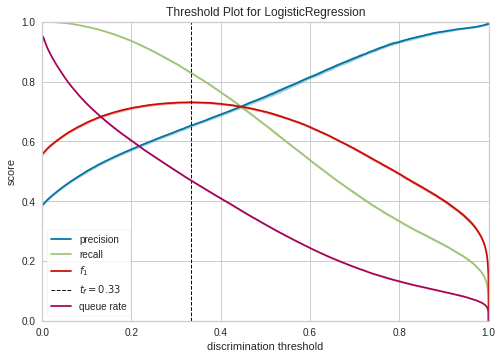

In [10]:
visualizer = DiscriminationThreshold(lr)
visualizer.fit(X_train, y_train)
visualizer.show()

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.01, 0.1, 0.5, 1, 5]}, return_train_score=True,
             verbose=1)
               precision    recall  f1-score   support

         0.0       0.81      0.88      0.84     25383
         1.0       0.76      0.66      0.71     15046

    accuracy                           0.80     40429
   macro avg       0.79      0.77      0.77     40429
weighted avg       0.79      0.80      0.79     40429

best params: {'C': 5}, score: 0.7962353755967251


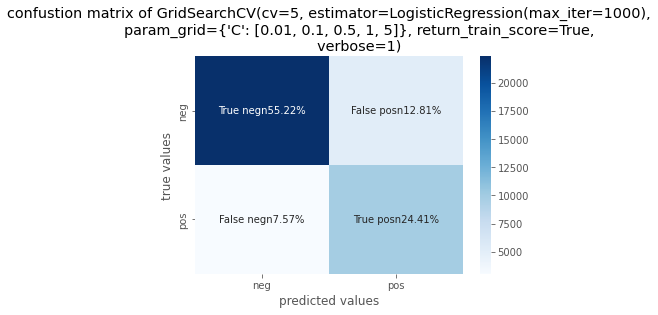

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
def scr(clf, x_val, ytrue):
        y_pred = (clf.predict(x_val) >= 0.5).astype(int)
        cm = confusion_matrix(y_pred, ytrue)
        cats = ['neg', 'pos']
        groups = ['True neg', 'False pos', 'False neg', 'True pos']
        group_percents = ['{0:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)]
        labels = [f'{v1} {v2}' for v1, v2 in zip(groups, group_percents)]
        labels = np.asarray(labels).reshape(2, 2)
        sns.heatmap(cm, annot=labels, cmap='Blues', xticklabels=cats, yticklabels=cats, fmt='')
        plt.xlabel('predicted values')
        plt.ylabel('true values')
        plt.title(f'confusion matrix of {clf}')
        print(f'{clf}\n', classification_report(ytrue, y_pred))
        #print(f'best params: {clf.best_params_}, score: {clf.score(x_val, ytrue)}')
scr(lr, X_test, y_test)